In [1]:
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
import sys
import os
import numpy as np
import pandas as pd
from anndata import AnnData

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import scanpy as sc
import os
from numpy.random import seed
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pdb
import h5py
import copy

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.preprocessing import OneHotEncoder

seed(20211215)
np.random.seed(20211215)

#### 1. Load data

In [2]:
def Read_tissue(data_dir, tissue):
    matrices = {}
    g = os.walk(data_dir)
    for path, dir_list, file_list in g:
        for file_name in file_list:
            if 'csv' in file_name and tissue in file_name:
                print(os.path.join(path, file_name))
                pd_reader = pd.read_csv(os.path.join(path, file_name), index_col=0)
                matrices[tissue] = pd_reader
    return matrices

In [3]:
data_dir = 'FACS'
stats_df = pd.read_csv(f'annotations_facs.csv')
tissue = 'Heart'
matrices = Read_tissue(data_dir, tissue)

FACS\Heart-counts.csv


#### 2. Construct dataframe

In [4]:
tissue_df = matrices[tissue]
tissue_df = tissue_df.join(stats_df.set_index('cell'))
tissue_df = tissue_df[tissue_df['tissue']==tissue]
tissue_df = tissue_df[tissue_df['mouse.id']!='3_38_F/3_39_F']
tissue_df = tissue_df[tissue_df['mouse.id']!='3_10_M/3_11_M']
tissue_df.dropna(subset = ["cell_ontology_id"], inplace=True)

In [5]:
mice = tissue_df['mouse.id'].value_counts().index
label_dict = {}
for i in range(mice.shape[0]):
    label_dict[str(i+1)] = mice[i]

In [6]:
# Draw cell_type_distribution plot
# Marrow_3_39_F = stats_df[(stats_df['mouse.id'] == '3_39_F')  & (stats_df['tissue'] == 'Marrow')]['cell_ontology_class'].value_counts()
# Marrow_3_38_F = stats_df[(stats_df['mouse.id'] == '3_38_F')  & (stats_df['tissue'] == 'Marrow')]['cell_ontology_class'].value_counts()
# Marrow_3_8_M = stats_df[(stats_df['mouse.id'] == '3_8_M')  & (stats_df['tissue'] == 'Marrow')]['cell_ontology_class'].value_counts()
# Marrow_3_9_M = stats_df[(stats_df['mouse.id'] == '3_9_M')  & (stats_df['tissue'] == 'Marrow')]['cell_ontology_class'].value_counts()
# Marrow_3_10_M = stats_df[(stats_df['mouse.id'] == '3_10_M')  & (stats_df['tissue'] == 'Marrow')]['cell_ontology_class'].value_counts()
# fig = Marrow_3_10_M.plot(kind='bar').get_figure()
# fig.savefig('../Marrow_3_10_M.png', bbox_inches='tight')

In [7]:
info = tissue_df.iloc[:,-23:].reset_index(drop=True)
genes = tissue_df.iloc[:,:-23].reset_index(drop=True)

#### 3. Preprocessing

In [8]:
adata = sc.AnnData(genes)

In [9]:
# Draw UMAP for mouse_id
# inverse_dict = {}
# for k, i in label_dict.items():
#     inverse_dict[i] = int(k)
# mouse_id = tissue_df['mouse.id'].map(inverse_dict)
# from sklearn.manifold import TSNE
# def discrete_cmap(n, base_cmap=None):
#         """Create an N-bin discrete colormap from the specified input map"""
#         base = plt.cm.get_cmap(base_cmap)
#         return base.from_list(base.name + str(n), base(np.linspace(0, 1, n)), n)

# latent_representations=TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(adata.X)
# labels=np.asarray(mouse_id)
# plt.figure(figsize=(10, 10))
# plt.scatter(latent_representations[:, 0], latent_representations[:, 1], cmap=discrete_cmap(10, 'jet'), c=labels, edgecolors='black')
# plt.colorbar()
# plt.grid()
# plt.show()

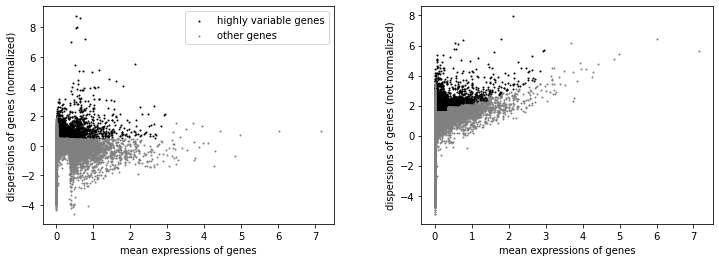

In [10]:
# Basic filtering:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Normalization:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
# Annotate highly variable genes 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

In [11]:
# PCA
X = adata.X.toarray()
# PCA
pca_dim = 50
pca = PCA(n_components=pca_dim, random_state=3456).fit(X)
X = pca.transform(X)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')

In [12]:
clusters = info['cell_ontology_id']
clusters = pd.DataFrame(clusters)  # groundtruth of all cells
idx = list(map(int, adata.obs.index))
clusters_reduce = clusters.iloc[idx].reset_index().rename(columns={"cell_ontology_id": "cluster"})

In [13]:
# one-hot encoder for cell-type-distribution
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(clusters_reduce['cluster']).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [14]:
labels = info['mouse.id']
stats = labels.value_counts()
label_group = {}
idx = list(map(int, adata.obs.index))
labels_temp = labels.iloc[idx].reset_index()
for i in range(stats.shape[0]):
    label_group[str(i+1)] = list(labels_temp[labels_temp['mouse.id']==stats.index[i]].index)

#### 4. Split dataset

In [25]:
train_idx = []
test_idx = []
for i in range(stats.shape[0]):
    i = str(i+1)
    index = label_group[i]
    rand_idx = copy.copy(index)
    np.random.shuffle(rand_idx)
    train_idx.append(rand_idx[:int(len(index)*0.6)])
    test_idx.append(rand_idx[int(len(index)*0.6):])

#### 5. Data_point simulation

In [21]:
def data_point_simulation(batch_size, pca_dim, X, clusters):
    # training bulk-dataset
    bulk_data_train = np.zeros([1, pca_dim])  # single-cell=pca_dim+cell_type_num, bulk-cell=pca_dim
    single_data_train = np.zeros([1, pca_dim+clusters.value_counts().shape[0]])
    labels_train = []
    for i in range(1000): # create 1000 bulk-seq data point bulk_size
        g = np.random.choice(np.arange(stats.shape[0]), 1)[0]
        idx = np.random.choice(train_idx[g], batch_size)
        mean = np.mean(X[np.array(idx), :pca_dim], axis=0).reshape(1,-1)
        #########################
        # only for single-cell dp construction
        cell_types = np.mean(enc.transform(np.array(clusters_reduce.iloc[idx]['cluster']).
                                          reshape(-1, 1)).toarray(), 0).reshape(1, -1)
        dp = np.concatenate((mean, cell_types), axis=1)
        #########################
        bulk_data_train = np.concatenate((bulk_data_train, mean), axis=0)
        single_data_train = np.concatenate((single_data_train, dp), axis=0)
        labels_train.append(label_dict[str(g+1)])
    bulk_data_train = bulk_data_train[1:]
    single_data_train = single_data_train[1:]

    # testing bulk-dataset
    bulk_data_test = np.zeros([1, pca_dim])  # single-cell=pca_dim+cell_type_num, bulk-cell=pca_dim
    single_data_test = np.zeros([1, pca_dim+clusters.value_counts().shape[0]])
    labels_test = []
    for i in range(8000): # create 800 bulk-seq data point bulk_size
        g = np.random.choice(np.arange(stats.shape[0]), 1)[0]
        idx = np.random.choice(test_idx[g], batch_size)
        mean = np.mean(X[np.array(idx), :pca_dim], axis=0).reshape(1,-1)
        #########################
        # only for single-cell dp construction
        cell_types = np.mean(enc.transform(np.array(clusters_reduce.iloc[idx]['cluster']).
                                          reshape(-1, 1)).toarray(), 0).reshape(1, -1)
        dp = np.concatenate((mean, cell_types), axis=1)
        #########################
        bulk_data_test = np.concatenate((bulk_data_test, mean), axis=0)
        single_data_test = np.concatenate((single_data_test, dp), axis=0)
        labels_test.append(label_dict[str(g+1)])
    bulk_data_test = bulk_data_test[1:]
    single_data_test = single_data_test[1:]
    
    return labels_train, bulk_data_train, single_data_train, labels_test, bulk_data_test, single_data_test

#### 6. Train and Test

In [22]:
def Random_Forest(data):
    labels_train, bulk_data_train, single_data_train, labels_test, bulk_data_test, single_data_test = \
        data[0], data[1], data[2], data[3], data[4], data[5]
    rep = 100
    bulk_accuracy = []
    single_accuracy = []
    
    # create a random forest model
    decision_tree_classifier_bulk = RandomForestClassifier(max_depth=3, n_estimators=50)  # need to fine-tune the hyperparameters
    decision_tree_classifier_single = RandomForestClassifier(max_depth=3, n_estimators=50)  # need to fine-tune the hyperparameters

    for _ in range(rep):
        decision_tree_classifier_bulk.fit(bulk_data_train, labels_train)  # select the best classifier
        y_test_predict_prob = decision_tree_classifier_bulk.predict_proba(bulk_data_test)
        bulk_accuracy.append(decision_tree_classifier_bulk.score(bulk_data_test, labels_test))

        decision_tree_classifier_single.fit(single_data_train, labels_train)  # select the best classifier
        y_test_predict_prob = decision_tree_classifier_single.predict_proba(single_data_test)
        single_accuracy.append(decision_tree_classifier_single.score(single_data_test, labels_test))

    print(f'The test accuracy for bulk cell is {np.mean(bulk_accuracy)}')
    print(f'The test accuracy for single cell is {np.mean(single_accuracy)}')
    return decision_tree_classifier_bulk, decision_tree_classifier_single

##### Baseline (using PCA)

In [26]:
simulate_data = data_point_simulation(50, pca_dim, X, clusters)

In [27]:
decision_tree_classifier_bulk, decision_tree_classifier_single = Random_Forest(simulate_data)

The test accuracy for bulk cell is 0.9052800000000001
The test accuracy for single cell is 0.9141600000000001


#### 7. Analysis

In [28]:
feature_importances = decision_tree_classifier_single.feature_importances_
feature_importances_indices = np.argsort(-feature_importances)

pca_importances = feature_importances[0:pca_dim]
cell_type_importances = feature_importances[pca_dim:]

pca_importances_indices = np.argsort(-pca_importances)
cell_type_importances_indices = np.argsort(-cell_type_importances)

for n in range(10, pca_dim+1, 10):
    top_n_indices = feature_importances_indices[0:n]
    is_cell_type_index = (top_n_indices >= pca_dim)
    print(f'There are {sum(is_cell_type_index)} cell type features in top {n} features.')

There are 1 cell type features in top 10 features.
There are 1 cell type features in top 20 features.
There are 2 cell type features in top 30 features.
There are 5 cell type features in top 40 features.
There are 6 cell type features in top 50 features.


##### Top_Gene

In [29]:
top_pca_indices = pca_importances_indices[0:10]

top_n_components = 50
num_selected_genes = 10

pca_components_abs = abs(pca.components_)
top_components_abs = pca_components_abs[top_pca_indices, :]

top_gene_for_pca_indices = np.argsort(-top_components_abs)[:, :top_n_components]

from collections import Counter
c = Counter(top_gene_for_pca_indices.flatten())

top_genes_tuple_list = sorted(list(zip(c.values(), c.keys())), reverse=True)[:num_selected_genes]
top_genes_indices = [gene_tuple[1] for gene_tuple in top_genes_tuple_list]

X_top_genes = adata.X.toarray()[:, top_genes_indices]

In [30]:
# random smapling
# X_top_genes = adata.X.toarray()[:, list(range(50))]

In [34]:
simulate_data = data_point_simulation(50, 50, X_top_genes, clusters)

In [35]:
decision_tree_classifier_bulk, decision_tree_classifier_single = Random_Forest(simulate_data)

The test accuracy for bulk cell is 0.397545
The test accuracy for single cell is 0.48739875


##### Weighted_top_genes 

In [52]:
top_pca_indices = pca_importances_indices[0:10]

top_n_components = 50
num_selected_genes = 10

pca_components_abs = abs(pca.components_)
top_components_abs = pca_components_abs[top_pca_indices, :]

singular_values = pca.singular_values_
top_singular_values = singular_values[top_pca_indices]
weighted_importances = np.transpose((np.transpose(top_components_abs) * top_singular_values))
weighted_sum = np.sum(weighted_importances, axis=0)

top_genes_weighted_indices = list(np.argsort(-weighted_sum)[:top_n_components])

X_top_genes_weighted = adata.X.toarray()[:, top_genes_weighted_indices]

In [55]:
simulate_data = data_point_simulation(50, num_selected_genes, X_top_genes_weighted, clusters)

In [56]:
decision_tree_classifier_bulk, decision_tree_classifier_single = Random_Forest(simulate_data)

The test accuracy for bulk cell is 0.9179050000000002
The test accuracy for single cell is 0.9044824999999999
